In [1]:
import sys
sys.path.append("/home/jarlehti/projects/gradu")

In [53]:
import os
import glob
from dataclasses import dataclass
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import d3p
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from src.napsu_mq.napsu_mq import NapsuMQResult
from scripts.constants import TRAIN_DATASET_SIZE_MAP, TRUE_COEFFICIENTS_FOR_DATASETS
from src.napsu_mq.logistic_regression import logistic_regression
from src.napsu_mq.rubins_rules import conf_int, non_negative_conf_int
from src.utils.data_utils import dataframe_list_to_tensor
from src.utils.preprocess_dataset import get_binary4d_train
from src.utils.data_utils import transform_for_classification
import pprint
from scipy.special import expit

In [3]:
CURRENT_FOLDER = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
DATASETS_FOLDER = os.path.join(CURRENT_FOLDER, "data", "datasets")
MODELS = os.path.join(CURRENT_FOLDER, "models")
BU_MODELS_FOLDER = os.path.join(os.path.dirname(CURRENT_FOLDER), "cluster_backup", "gradu_cluster_backup_05042023", "models")

In [4]:
model_files = glob.glob(os.path.join(MODELS, '*.dill'))

In [5]:
pprint.pprint([(i, m) for i, m in enumerate(model_files)])

[(0,
  '/home/local/jarlehti/projects/gradu/models/napsu_linear_regression_model_dummy_5x6_30e_18_repeat.dill'),
 (1,
  '/home/local/jarlehti/projects/gradu/models/napsu_original_model_adult_large_03e_age+hours-per-week.dill'),
 (2,
  '/home/local/jarlehti/projects/gradu/models/napsu_linear_regression_model_dummy_5x4_30e_15_repeat.dill'),
 (3,
  '/home/local/jarlehti/projects/gradu/models/napsu_linear_regression_model_dummy_5x7_03e_7_repeat.dill'),
 (4,
  '/home/local/jarlehti/projects/gradu/models/napsu_linear_regression_model_dummy_5x5_03e_19_repeat.dill'),
 (5,
  '/home/local/jarlehti/projects/gradu/models/napsu_original_model_binary4d_01e_A+D.dill'),
 (6,
  '/home/local/jarlehti/projects/gradu/models/napsu_original_model_adult_small_30e_age+hours-per-week.dill'),
 (7,
  '/home/local/jarlehti/projects/gradu/models/napsu_linear_regression_model_dummy_5x3_10e_13_repeat.dill'),
 (8,
  '/home/local/jarlehti/projects/gradu/models/napsu_linear_regression_model_dummy_5x3_10e_11_repeat.dill

In [8]:
# Open random model
model_path = os.path.join(model_files[23])
model_binary = open(model_path, "rb")
model = NapsuMQResult.load(model_binary)

In [6]:
model_path = os.path.join(BU_MODELS_FOLDER, "napsu_original_model_binary3d_80e_A+C-B+C.dill")
model_binary = open(model_path, "rb")
model = NapsuMQResult.load(model_binary)

In [7]:
model.meta

{'experiment_id': 'M9T8ZVNM',
 'dataset_name': 'binary3d',
 'query_str': 'A+C-B+C',
 'query_list': [['A', 'C'], ['B', 'C']],
 'epsilon': 8.0,
 'delta': 1e-10,
 'MCMC_algo': 'NUTS',
 'laplace_approximation': True,
 'missing_query': None,
 'discretization': None,
 'n_canonical_queries': 5,
 'junction_tree_width': 1,
 'suff_stat_dim': (5,),
 'laplace_approximation_algorithm': 'torch_LBFGS'}

In [8]:
dataset_name = model.meta['dataset_name']
n_original_datapoints = TRAIN_DATASET_SIZE_MAP[dataset_name]
print(n_original_datapoints)
true_params = TRUE_COEFFICIENTS_FOR_DATASETS[dataset_name]
print(true_params)

100000
[1.0, 0.0]


In [11]:
orig_df = pd.read_csv(os.path.join(DATASETS_FOLDER, "binary3d.csv"))

In [12]:
orig_df

,A,B,C
0,1,0,1
1,0,1,0
2,1,1,1
3,0,0,1
4,1,1,1
...,...,...,...
99995,1,0,1
99996,0,0,0
99997,1,0,1
99998,0,1,1


In [13]:
orig_df_np = orig_df.to_numpy()
print(np.mean(orig_df_np, axis=0))

X_array_orig = orig_df_np[:,:-1]
y_array_orig = orig_df_np[:,-1]
lr_model_orig = sm.GLM(y_array_orig, X_array_orig, family=sm.families.Binomial()).fit()
print(lr_model_orig.summary())

[0.49949 0.50193 0.61485]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63809.
Date:                Mon, 15 May 2023   Deviance:                   1.2762e+05
Time:                        15:28:38   Pearson chi2:                 1.00e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.05529
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0014     

In [14]:
original_params = lr_model_orig.params
print(original_params)

[ 1.00139286 -0.01020101]


Generating data with 100000 points and 100 datasets


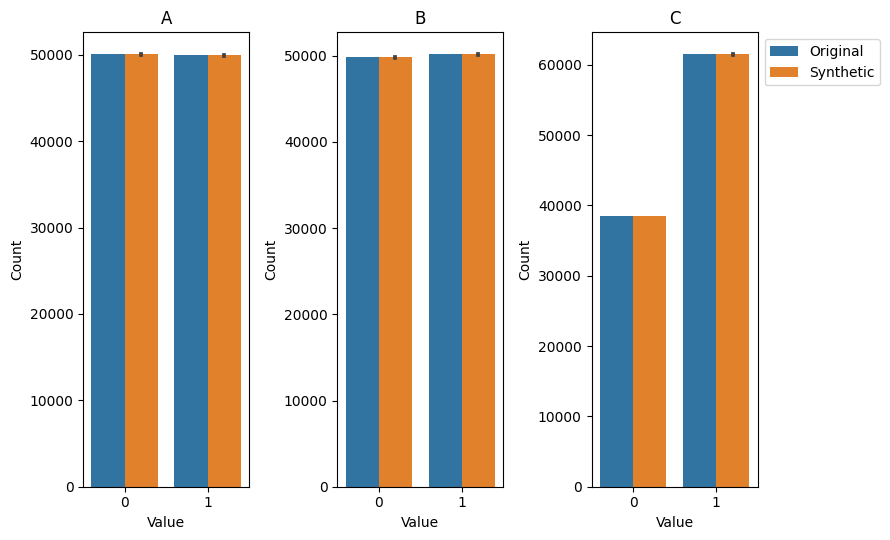

In [15]:
rng = jax.random.PRNGKey(32863812)
synthetic_dataset = model.generate(rng, n_original_datapoints, 100)


def value_count_list(df, col, type):
    counts = df[col].value_counts()
    return [(value, counts[value], type) for value in counts.index]

def value_count_df(orig_df, synthetic_dfs, col):
    vl_list = value_count_list(orig_df, col, "Original")
    for synthetic_df in synthetic_dfs:
        vl_list += (value_count_list(synthetic_df, col, "Synthetic"))

    return pd.DataFrame.from_records(vl_list, columns=["Value", "Count", "Type"])

value_count_dfs = { col: value_count_df(orig_df, synthetic_dataset, col) for col in orig_df.columns }

fig, axes = plt.subplots(1, len(value_count_dfs.items()), figsize=(3 * len(value_count_dfs.items()), 5.5))
for i, (key, value) in enumerate(value_count_dfs.items()):
    ax = axes[i]
    ax.set_title(key)
    ax.tick_params("x")
    sns.barplot(x="Value", y="Count", data=value_count_dfs[key], hue="Type", estimator=np.mean, ax=ax)
    if i < len(value_count_dfs.items()) - 1: 
        ax.get_legend().remove()
    else:
        ax.legend(loc="upper left", bbox_to_anchor=(1.00, 1))
        
plt.tight_layout()
plt.show()

In [16]:
synthetic_dataset[0]

,A,B,C
0,1,1,1
1,1,0,1
2,1,1,1
3,0,1,1
4,0,0,0
...,...,...,...
99995,0,0,1
99996,1,0,0
99997,1,0,0
99998,0,0,0


In [19]:
synthetic_dfs_np = np.concatenate(synthetic_dataset, axis=0)
synthetic_dfs_np = synthetic_dfs_np.astype(int)
print(np.mean(synthetic_dfs_np, axis=0))
X_array_syn = synthetic_dfs_np[:,:-1]
y_array_syn = synthetic_dfs_np[:,-1]
lr_model_syn = sm.GLM(y_array_syn, X_array_syn, family=sm.families.Binomial()).fit()
print(lr_model_syn.summary())

[0.4994664 0.5017566 0.6149244]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:             10000000
Model:                            GLM   Df Residuals:                  9999998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.3792e+06
Date:                Mon, 15 May 2023   Deviance:                   1.2758e+07
Time:                        15:30:16   Pearson chi2:                 1.00e+07
No. Iterations:                     5   Pseudo R-squ. (CS):            0.05555
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.003

In [20]:
synthetic_dfs_np = np.concatenate(synthetic_dataset, axis=0)
print(np.mean(synthetic_dfs_np, axis=0))
noisy_synthetic_df_np = synthetic_dfs_np + np.random.normal(scale=0.1, size=synthetic_dfs_np.shape)
X_array_noisy_syn = noisy_synthetic_df_np[:,:-1]
y_array_noisy_syn = noisy_synthetic_df_np[:,-1]
lr_model_noisy_syn = sm.GLM(y_array_noisy_syn, sm.add_constant(X_array_noisy_syn), family=sm.families.Binomial()).fit()
print(lr_model_noisy_syn.summary())

[0.4994664 0.5017566 0.6149244]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
params = lr_model_syn.params
predictions = expit(synthetic_dfs_np[:,:-1] @ params)
sns.regplot(x=predictions[0:5000], y=synthetic_dfs_np[:,3][0:5000], logistic=True)

In [ ]:
orig_df_np = orig_df.to_numpy()
X_array_orig = orig_df_np[:,:-1]
y_array_orig = orig_df_np[:,-1]
lr_model_orig =  sm.GLM(y_array_orig, X_array_orig, family=sm.families.Binomial()).fit()
print(lr_model_orig.summary())

In [ ]:
np.unique(synthetic_dfs_np)

In [ ]:
params_orig = lr_model_orig.params
predictions_orig = expit(orig_df_np[:,:-1] @ params_orig)

sns.regplot(x=predictions_orig[0:5000], y=orig_df_np[:,3][0:5000], logistic=True)

In [21]:
q = np.zeros((len(synthetic_dataset), 3))
u = np.zeros((len(synthetic_dataset), 3))

for i, syn_df in enumerate(synthetic_dataset):
    X_array_syn = syn_df.to_numpy()[:,:-1]
    y_array_syn = syn_df.to_numpy()[:,-1]
        
    logistic_regression_result_with_syn = sm.GLM(y_array_syn, X_array_syn, family=sm.families.Binomial()).fit()
    
    q[i, :] = logistic_regression_result_with_syn.params
    u[i, :] = logistic_regression_result_with_syn.bse**2
    
print(f"Expectation for param 1: {np.mean(q[:,0])}")
print(f"Expectation for param 2: {np.mean(q[:,1])}")
print(f"Expectation for param 3: {np.mean(q[:,2])}")
# print(f"Expectation for param 3: {np.mean(q[:,3])}")

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [33]:
rng = jax.random.PRNGKey(2356991365)
sampling_rngs = jax.random.split(rng, n_repeats * len(n_datasets))

ci_data_objects = []

for n in range(n_repeats):
    print(f"Round: {n}")
    for interval in confidence_intervals:
        for i, n_dataset in enumerate(n_datasets):
            print(f"Generating {n_dataset} datasets for interval {interval}")
            sampling_index = n + i
            datasets = model.generate(sampling_rngs[sampling_index], n_original_datapoints, n_dataset)
            
            syn_data_n, syn_data_d = datasets[0].shape
            datasets_np = dataframe_list_to_tensor(datasets)
            
            datasets_np = datasets_np.astype(int)
            
            q, u = logistic_regression(datasets_np, add_constant=False)
            
            for d in range(len(true_params)):
                q_i = q[:,d]
                u_i = u[:,d]
                
                inds = (u_i < 1000)
                q_i = q_i[inds]
                u_i = u_i[inds]

                if len(u_i) == 0:
                    q_i = np.array(np.nan)
                    u_i = np.array(np.nan)
                
                ci_result = conf_int(q_i, u_i, interval)
                nn_ci_result = non_negative_conf_int(q_i, u_i, interval, syn_data_n, n_original_datapoints)
                
                if np.isnan(ci_result[0]) or np.isnan(ci_result[1]) or np.isnan(nn_ci_result[0]) or np.isnan(nn_ci_result[1]):
                    print(f"WARNING: Confidence interval had nan: {ci_result}, nn {nn_ci_result}")

                true_param_value = true_params[d]
                
                contains_true_value = ci_result[0] <= true_param_value <= ci_result[1]
                contains_true_value_nn = nn_ci_result[0] <= true_param_value <= nn_ci_result[1]

                
                print(f"True param value: {true_param_value}, confidence interval: {ci_result[0]} - {ci_result[1]}, nn confidence interval: {nn_ci_result[0]} - {nn_ci_result[1]}")

                conf_int_object = ConfidenceIntervalObject(
                    original_dataset_name = dataset_name,
                    index = n,
                    n_datasets = n_dataset,
                    conf_int_range = interval,
                    conf_int_start = ci_result[0],
                    conf_int_end = ci_result[1],
                    conf_int_width = ci_result[1] - ci_result[0],
                    true_parameter_value = true_param_value,
                    contains_true_parameter = ci_result[0] <= true_param_value <= ci_result[1],
                    nn_conf_int_start = nn_ci_result[0],
                    nn_conf_int_end = nn_ci_result[1],
                    nn_conf_int_width = nn_ci_result[1] - nn_ci_result[0],
                    contains_true_parameter_nn = nn_ci_result[0] <= true_param_value <= nn_ci_result[1],
                    parameter_index = d,
                    meta = {
                        'epsilon': model.meta['epsilon']
                    }
                )
                
                ci_data_objects.append(conf_int_object)
                
                print(conf_int_object.to_dict())

Round: 0
Generating 50 datasets for interval 0.05
Generating data with 100000 points and 50 datasets
True param value: 1.0013928615336594, confidence interval: 1.001992736611543 - 1.0029826037041751, nn confidence interval: 1.001992736611543 - 1.0029826037041751
{'original_dataset_name': 'binary3d', 'index': 0, 'n_datasets': 50, 'conf_int_range': 0.05, 'conf_int_start': 1.001992736611543, 'conf_int_end': 1.0029826037041751, 'conf_int_width': 0.0009898670926320463, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': False, 'nn_conf_int_start': 1.001992736611543, 'nn_conf_int_end': 1.0029826037041751, 'nn_conf_int_width': 0.0009898670926320463, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.009186476991131802 - -0.007599169412292687, nn confidence interval: -0.009186476991131802 - -0.007599169412292687
{'original_dataset_name': 'binary3d', 'index': 0, 'n_datasets': 50, 'conf_int_range': 0.05, 'conf_int_start': -0.

True param value: 1.0013928615336594, confidence interval: 0.998277331654653 - 1.006698008661065, nn confidence interval: 0.998277331654653 - 1.006698008661065
{'original_dataset_name': 'binary3d', 'index': 0, 'n_datasets': 50, 'conf_int_range': 0.4, 'conf_int_start': 0.998277331654653, 'conf_int_end': 1.006698008661065, 'conf_int_width': 0.008420677006412025, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.998277331654653, 'nn_conf_int_end': 1.006698008661065, 'nn_conf_int_width': 0.008420677006412025, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.015058463655573241 - -0.001727182747851253, nn confidence interval: -0.015058463655573241 - -0.001727182747851253
{'original_dataset_name': 'binary3d', 'index': 0, 'n_datasets': 50, 'conf_int_range': 0.4, 'conf_int_start': -0.015058463655573241, 'conf_int_end': -0.001727182747851253, 'conf_int_width': 0.013331280907721989, 'true_param

True param value: 1.0013928615336594, confidence interval: 0.9926043200883621 - 1.0123710202273561, nn confidence interval: 0.9926043200883621 - 1.0123710202273561
{'original_dataset_name': 'binary3d', 'index': 0, 'n_datasets': 50, 'conf_int_range': 0.75, 'conf_int_start': 0.9926043200883621, 'conf_int_end': 1.0123710202273561, 'conf_int_width': 0.019766700138994064, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9926043200883621, 'nn_conf_int_end': 1.0123710202273561, 'nn_conf_int_width': 0.019766700138994064, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.023261048807646127 - 0.006475402404221637, nn confidence interval: -0.023261048807646127 - 0.006475402404221637
{'original_dataset_name': 'binary3d', 'index': 0, 'n_datasets': 50, 'conf_int_range': 0.75, 'conf_int_start': -0.023261048807646127, 'conf_int_end': 0.006475402404221637, 'conf_int_width': 0.029736451211867763, 'tru

True param value: 1.0013928615336594, confidence interval: 1.0051119102985704 - 1.0090503474947938, nn confidence interval: 1.0051119102985704 - 1.0090503474947938
{'original_dataset_name': 'binary3d', 'index': 1, 'n_datasets': 50, 'conf_int_range': 0.15, 'conf_int_start': 1.0051119102985704, 'conf_int_end': 1.0090503474947938, 'conf_int_width': 0.003938437196223443, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': False, 'nn_conf_int_start': 1.0051119102985704, 'nn_conf_int_end': 1.0090503474947938, 'nn_conf_int_width': 0.003938437196223443, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.016382123265715386 - -0.012421286528186134, nn confidence interval: -0.016382123265715386 - -0.012421286528186134
{'original_dataset_name': 'binary3d', 'index': 1, 'n_datasets': 50, 'conf_int_range': 0.15, 'conf_int_start': -0.016382123265715386, 'conf_int_end': -0.012421286528186134, 'conf_int_width': 0.003960836737529252, 

True param value: 1.0013928615336594, confidence interval: 0.9999759988494227 - 1.0141862589439417, nn confidence interval: 0.9999759988494227 - 1.0141862589439417
{'original_dataset_name': 'binary3d', 'index': 1, 'n_datasets': 50, 'conf_int_range': 0.5, 'conf_int_start': 0.9999759988494227, 'conf_int_end': 1.0141862589439417, 'conf_int_width': 0.014210260094518978, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9999759988494227, 'nn_conf_int_end': 1.0141862589439417, 'nn_conf_int_width': 0.014210260094518978, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.021534181077720427 - -0.007269228716181092, nn confidence interval: -0.021534181077720427 - -0.007269228716181092
{'original_dataset_name': 'binary3d', 'index': 1, 'n_datasets': 50, 'conf_int_range': 0.5, 'conf_int_start': -0.021534181077720427, 'conf_int_end': -0.007269228716181092, 'conf_int_width': 0.014264952361539334, 'tr

True param value: 1.0013928615336594, confidence interval: 0.9912103357477763 - 1.022951922045588, nn confidence interval: 0.9912103357477763 - 1.022951922045588
{'original_dataset_name': 'binary3d', 'index': 1, 'n_datasets': 50, 'conf_int_range': 0.85, 'conf_int_start': 0.9912103357477763, 'conf_int_end': 1.022951922045588, 'conf_int_width': 0.031741586297811764, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9912103357477763, 'nn_conf_int_end': 1.022951922045588, 'nn_conf_int_width': 0.031741586297811764, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.030217880734284615 - 0.0014144709403831005, nn confidence interval: -0.030217880734284615 - 0.0014144709403831005
{'original_dataset_name': 'binary3d', 'index': 1, 'n_datasets': 50, 'conf_int_range': 0.85, 'conf_int_start': -0.030217880734284615, 'conf_int_end': 0.0014144709403831005, 'conf_int_width': 0.031632351674667714, 'true

True param value: 1.0013928615336594, confidence interval: 0.9960349226408988 - 1.0034070998176194, nn confidence interval: 0.9960349226408988 - 1.0034070998176194
{'original_dataset_name': 'binary3d', 'index': 2, 'n_datasets': 50, 'conf_int_range': 0.25, 'conf_int_start': 0.9960349226408988, 'conf_int_end': 1.0034070998176194, 'conf_int_width': 0.007372177176720673, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9960349226408988, 'nn_conf_int_end': 1.0034070998176194, 'nn_conf_int_width': 0.007372177176720673, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.014285981522040109 - -0.008379530016456471, nn confidence interval: -0.014285981522040109 - -0.008379530016456471
{'original_dataset_name': 'binary3d', 'index': 2, 'n_datasets': 50, 'conf_int_range': 0.25, 'conf_int_start': -0.014285981522040109, 'conf_int_end': -0.008379530016456471, 'conf_int_width': 0.0059064515055836375, 

True param value: 1.0013928615336594, confidence interval: 0.9898559810347609 - 1.0095860414237572, nn confidence interval: 0.9898559810347609 - 1.0095860414237572
{'original_dataset_name': 'binary3d', 'index': 2, 'n_datasets': 50, 'conf_int_range': 0.6, 'conf_int_start': 0.9898559810347609, 'conf_int_end': 1.0095860414237572, 'conf_int_width': 0.019730060388996273, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9898559810347609, 'nn_conf_int_end': 1.0095860414237572, 'nn_conf_int_width': 0.019730060388996273, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.019284285018253258 - -0.00338122652024332, nn confidence interval: -0.019284285018253258 - -0.00338122652024332
{'original_dataset_name': 'binary3d', 'index': 2, 'n_datasets': 50, 'conf_int_range': 0.6, 'conf_int_start': -0.019284285018253258, 'conf_int_end': -0.00338122652024332, 'conf_int_width': 0.015903058498009937, 'true_

True param value: 1.0013928615336594, confidence interval: 0.975088740667959 - 1.024353281790559, nn confidence interval: 0.975088740667959 - 1.024353281790559
{'original_dataset_name': 'binary3d', 'index': 2, 'n_datasets': 50, 'conf_int_range': 0.95, 'conf_int_start': 0.975088740667959, 'conf_int_end': 1.024353281790559, 'conf_int_width': 0.049264541122599925, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.975088740667959, 'nn_conf_int_end': 1.024353281790559, 'nn_conf_int_width': 0.049264541122599925, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.031854661685183125 - 0.009189150146686548, nn confidence interval: -0.031854661685183125 - 0.009189150146686548
{'original_dataset_name': 'binary3d', 'index': 2, 'n_datasets': 50, 'conf_int_range': 0.95, 'conf_int_start': -0.031854661685183125, 'conf_int_end': 0.009189150146686548, 'conf_int_width': 0.04104381183186967, 'true_paramet

True param value: 1.0013928615336594, confidence interval: 0.9960811014108848 - 1.006460479575729, nn confidence interval: 0.9960811014108848 - 1.006460479575729
{'original_dataset_name': 'binary3d', 'index': 3, 'n_datasets': 50, 'conf_int_range': 0.35, 'conf_int_start': 0.9960811014108848, 'conf_int_end': 1.006460479575729, 'conf_int_width': 0.010379378164844244, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9960811014108848, 'nn_conf_int_end': 1.006460479575729, 'nn_conf_int_width': 0.010379378164844244, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.015517981961351835 - -0.004875491597517589, nn confidence interval: -0.015517981961351835 - -0.004875491597517589
{'original_dataset_name': 'binary3d', 'index': 3, 'n_datasets': 50, 'conf_int_range': 0.35, 'conf_int_start': -0.015517981961351835, 'conf_int_end': -0.004875491597517589, 'conf_int_width': 0.010642490363834245, 'true

True param value: 1.0013928615336594, confidence interval: 0.989183675471655 - 1.0133579055149589, nn confidence interval: 0.989183675471655 - 1.0133579055149589
{'original_dataset_name': 'binary3d', 'index': 3, 'n_datasets': 50, 'conf_int_range': 0.7, 'conf_int_start': 0.989183675471655, 'conf_int_end': 1.0133579055149589, 'conf_int_width': 0.02417423004330388, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.989183675471655, 'nn_conf_int_end': 1.0133579055149589, 'nn_conf_int_width': 0.02417423004330388, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.022547417977924186 - 0.0021539444190547593, nn confidence interval: -0.022547417977924186 - 0.0021539444190547593
{'original_dataset_name': 'binary3d', 'index': 3, 'n_datasets': 50, 'conf_int_range': 0.7, 'conf_int_start': -0.022547417977924186, 'conf_int_end': 0.0021539444190547593, 'conf_int_width': 0.024701362396978947, 'true_par

True param value: 1.0013928615336594, confidence interval: 0.9974569102845963 - 0.999776188855674, nn confidence interval: 0.9974569102845963 - 0.999776188855674
{'original_dataset_name': 'binary3d', 'index': 4, 'n_datasets': 50, 'conf_int_range': 0.1, 'conf_int_start': 0.9974569102845963, 'conf_int_end': 0.999776188855674, 'conf_int_width': 0.002319278571077721, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': False, 'nn_conf_int_start': 0.9974569102845963, 'nn_conf_int_end': 0.999776188855674, 'nn_conf_int_width': 0.002319278571077721, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.009679914176887591 - -0.007052680719661337, nn confidence interval: -0.009679914176887591 - -0.007052680719661337
{'original_dataset_name': 'binary3d', 'index': 4, 'n_datasets': 50, 'conf_int_range': 0.1, 'conf_int_start': -0.009679914176887591, 'conf_int_end': -0.007052680719661337, 'conf_int_width': 0.002627233457226254, 'true_

True param value: 1.0013928615336594, confidence interval: 0.9930280577464671 - 1.004205041393803, nn confidence interval: 0.9930280577464671 - 1.004205041393803
{'original_dataset_name': 'binary3d', 'index': 4, 'n_datasets': 50, 'conf_int_range': 0.45, 'conf_int_start': 0.9930280577464671, 'conf_int_end': 1.004205041393803, 'conf_int_width': 0.011176983647335992, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9930280577464671, 'nn_conf_int_end': 1.004205041393803, 'nn_conf_int_width': 0.011176983647335992, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.014665007199569709 - -0.002067587696979219, nn confidence interval: -0.014665007199569709 - -0.002067587696979219
{'original_dataset_name': 'binary3d', 'index': 4, 'n_datasets': 50, 'conf_int_range': 0.45, 'conf_int_start': -0.014665007199569709, 'conf_int_end': -0.002067587696979219, 'conf_int_width': 0.012597419502590489, 'true

True param value: 1.0013928615336594, confidence interval: 0.9860226214240976 - 1.0112104777161726, nn confidence interval: 0.9860226214240976 - 1.0112104777161726
{'original_dataset_name': 'binary3d', 'index': 4, 'n_datasets': 50, 'conf_int_range': 0.8, 'conf_int_start': 0.9860226214240976, 'conf_int_end': 1.0112104777161726, 'conf_int_width': 0.025187856292074984, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9860226214240976, 'nn_conf_int_end': 1.0112104777161726, 'nn_conf_int_width': 0.025187856292074984, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.022285977222254838 - 0.0055533823257059075, nn confidence interval: -0.022285977222254838 - 0.0055533823257059075
{'original_dataset_name': 'binary3d', 'index': 4, 'n_datasets': 50, 'conf_int_range': 0.8, 'conf_int_start': -0.022285977222254838, 'conf_int_end': 0.0055533823257059075, 'conf_int_width': 0.027839359547960747, 'tr

True param value: 1.0013928615336594, confidence interval: 0.9982603613726886 - 1.0038929230669134, nn confidence interval: 0.9982603613726886 - 1.0038929230669134
{'original_dataset_name': 'binary3d', 'index': 5, 'n_datasets': 50, 'conf_int_range': 0.2, 'conf_int_start': 0.9982603613726886, 'conf_int_end': 1.0038929230669134, 'conf_int_width': 0.005632561694224769, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9982603613726886, 'nn_conf_int_end': 1.0038929230669134, 'nn_conf_int_width': 0.005632561694224769, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.012507509829757539 - -0.0063131214223502135, nn confidence interval: -0.012507509829757539 - -0.0063131214223502135
{'original_dataset_name': 'binary3d', 'index': 5, 'n_datasets': 50, 'conf_int_range': 0.2, 'conf_int_start': -0.012507509829757539, 'conf_int_end': -0.0063131214223502135, 'conf_int_width': 0.006194388407407325, 

True param value: 1.0013928615336594, confidence interval: 0.9925779101376883 - 1.0095753743019138, nn confidence interval: 0.9925779101376883 - 1.0095753743019138
{'original_dataset_name': 'binary3d', 'index': 5, 'n_datasets': 50, 'conf_int_range': 0.55, 'conf_int_start': 0.9925779101376883, 'conf_int_end': 1.0095753743019138, 'conf_int_width': 0.01699746416422554, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9925779101376883, 'nn_conf_int_end': 1.0095753743019138, 'nn_conf_int_width': 0.01699746416422554, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.018724763378220804 - -9.58678738869484e-05, nn confidence interval: -0.018724763378220804 - -9.58678738869484e-05
{'original_dataset_name': 'binary3d', 'index': 5, 'n_datasets': 50, 'conf_int_range': 0.55, 'conf_int_start': -0.018724763378220804, 'conf_int_end': -9.58678738869484e-05, 'conf_int_width': 0.018628895504333855, 'tr

True param value: 1.0013928615336594, confidence interval: 0.9815921540430261 - 1.0205611303965758, nn confidence interval: 0.9815921540430261 - 1.0205611303965758
{'original_dataset_name': 'binary3d', 'index': 5, 'n_datasets': 50, 'conf_int_range': 0.9, 'conf_int_start': 0.9815921540430261, 'conf_int_end': 1.0205611303965758, 'conf_int_width': 0.03896897635354968, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9815921540430261, 'nn_conf_int_end': 1.0205611303965758, 'nn_conf_int_width': 0.03896897635354968, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.030448175072861884 - 0.011627543820754127, nn confidence interval: -0.030448175072861884 - 0.011627543820754127
{'original_dataset_name': 'binary3d', 'index': 5, 'n_datasets': 50, 'conf_int_range': 0.9, 'conf_int_start': -0.030448175072861884, 'conf_int_end': 0.011627543820754127, 'conf_int_width': 0.04207571889361601, 'true_par

True param value: 1.0013928615336594, confidence interval: 0.9996491089142626 - 1.0114411751776329, nn confidence interval: 0.9996491089142626 - 1.0114411751776329
{'original_dataset_name': 'binary3d', 'index': 6, 'n_datasets': 50, 'conf_int_range': 0.3, 'conf_int_start': 0.9996491089142626, 'conf_int_end': 1.0114411751776329, 'conf_int_width': 0.01179206626337026, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9996491089142626, 'nn_conf_int_end': 1.0114411751776329, 'nn_conf_int_width': 0.01179206626337026, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.019508380143636816 - -0.009292179376058977, nn confidence interval: -0.019508380143636816 - -0.009292179376058977
{'original_dataset_name': 'binary3d', 'index': 6, 'n_datasets': 50, 'conf_int_range': 0.3, 'conf_int_start': -0.019508380143636816, 'conf_int_end': -0.009292179376058977, 'conf_int_width': 0.01021620076757784, 'true_

True param value: 1.0013928615336594, confidence interval: 0.9911093256675388 - 1.0199809584243569, nn confidence interval: 0.9911093256675388 - 1.0199809584243569
{'original_dataset_name': 'binary3d', 'index': 6, 'n_datasets': 50, 'conf_int_range': 0.65, 'conf_int_start': 0.9911093256675388, 'conf_int_end': 1.0199809584243569, 'conf_int_width': 0.028871632756818033, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9911093256675388, 'nn_conf_int_end': 1.0199809584243569, 'nn_conf_int_width': 0.028871632756818033, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.02692266581123854 - -0.001877893708457255, nn confidence interval: -0.02692266581123854 - -0.001877893708457255
{'original_dataset_name': 'binary3d', 'index': 6, 'n_datasets': 50, 'conf_int_range': 0.65, 'conf_int_start': -0.02692266581123854, 'conf_int_end': -0.001877893708457255, 'conf_int_width': 0.025044772102781283, 'tru

True param value: 1.0013928615336594, confidence interval: 0.9971169710530684 - 0.9985473689117238, nn confidence interval: 0.9971169710530684 - 0.9985473689117238
{'original_dataset_name': 'binary3d', 'index': 7, 'n_datasets': 50, 'conf_int_range': 0.05, 'conf_int_start': 0.9971169710530684, 'conf_int_end': 0.9985473689117238, 'conf_int_width': 0.0014303978586553967, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': False, 'nn_conf_int_start': 0.9971169710530684, 'nn_conf_int_end': 0.9985473689117238, 'nn_conf_int_width': 0.0014303978586553967, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.007529533004005358 - -0.006114100732134789, nn confidence interval: -0.007529533004005358 - -0.006114100732134789
{'original_dataset_name': 'binary3d', 'index': 7, 'n_datasets': 50, 'conf_int_range': 0.05, 'conf_int_start': -0.007529533004005358, 'conf_int_end': -0.006114100732134789, 'conf_int_width': 0.001415432271870569

True param value: 1.0013928615336594, confidence interval: 0.9918150561802438 - 1.0038492837845485, nn confidence interval: 0.9918150561802438 - 1.0038492837845485
{'original_dataset_name': 'binary3d', 'index': 7, 'n_datasets': 50, 'conf_int_range': 0.4, 'conf_int_start': 0.9918150561802438, 'conf_int_end': 1.0038492837845485, 'conf_int_width': 0.012034227604304726, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9918150561802438, 'nn_conf_int_end': 1.0038492837845485, 'nn_conf_int_width': 0.012034227604304726, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.012771911644656787 - -0.0008717220914833635, nn confidence interval: -0.012771911644656787 - -0.0008717220914833635
{'original_dataset_name': 'binary3d', 'index': 7, 'n_datasets': 50, 'conf_int_range': 0.4, 'conf_int_start': -0.012771911644656787, 'conf_int_end': -0.0008717220914833635, 'conf_int_width': 0.011900189553173422, 

True param value: 1.0013928615336594, confidence interval: 0.9843190805961657 - 1.0113452593686265, nn confidence interval: 0.9843190805961657 - 1.0113452593686265
{'original_dataset_name': 'binary3d', 'index': 7, 'n_datasets': 50, 'conf_int_range': 0.75, 'conf_int_start': 0.9843190805961657, 'conf_int_end': 1.0113452593686265, 'conf_int_width': 0.02702617877246083, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9843190805961657, 'nn_conf_int_end': 1.0113452593686265, 'nn_conf_int_width': 0.02702617877246083, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.020148534761472922 - 0.0065049010253327745, nn confidence interval: -0.020148534761472922 - 0.0065049010253327745
{'original_dataset_name': 'binary3d', 'index': 7, 'n_datasets': 50, 'conf_int_range': 0.75, 'conf_int_start': -0.020148534761472922, 'conf_int_end': 0.0065049010253327745, 'conf_int_width': 0.026653435786805697, 'tr

True param value: 1.0013928615336594, confidence interval: 1.001811444508357 - 1.0047709369643496, nn confidence interval: 1.001811444508357 - 1.0047709369643496
{'original_dataset_name': 'binary3d', 'index': 8, 'n_datasets': 50, 'conf_int_range': 0.15, 'conf_int_start': 1.001811444508357, 'conf_int_end': 1.0047709369643496, 'conf_int_width': 0.002959492455992585, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': False, 'nn_conf_int_start': 1.001811444508357, 'nn_conf_int_end': 1.0047709369643496, 'nn_conf_int_width': 0.002959492455992585, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.013448827516460263 - -0.010806987412491198, nn confidence interval: -0.013448827516460263 - -0.010806987412491198
{'original_dataset_name': 'binary3d', 'index': 8, 'n_datasets': 50, 'conf_int_range': 0.15, 'conf_int_start': -0.013448827516460263, 'conf_int_end': -0.010806987412491198, 'conf_int_width': 0.0026418401039690655, 'tr

True param value: 1.0013928615336594, confidence interval: 0.9978656578293419 - 1.0087167236433647, nn confidence interval: 0.9978656578293419 - 1.0087167236433647
{'original_dataset_name': 'binary3d', 'index': 8, 'n_datasets': 50, 'conf_int_range': 0.5, 'conf_int_start': 0.9978656578293419, 'conf_int_end': 1.0087167236433647, 'conf_int_width': 0.010851065814022842, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9978656578293419, 'nn_conf_int_end': 1.0087167236433647, 'nn_conf_int_width': 0.010851065814022842, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.016998655890824138 - -0.0072571590381273225, nn confidence interval: -0.016998655890824138 - -0.0072571590381273225
{'original_dataset_name': 'binary3d', 'index': 8, 'n_datasets': 50, 'conf_int_range': 0.5, 'conf_int_start': -0.016998655890824138, 'conf_int_end': -0.0072571590381273225, 'conf_int_width': 0.009741496852696815, 

True param value: 1.0013928615336594, confidence interval: 0.9903527759143747 - 1.016229605558332, nn confidence interval: 0.9903527759143747 - 1.016229605558332
{'original_dataset_name': 'binary3d', 'index': 8, 'n_datasets': 50, 'conf_int_range': 0.85, 'conf_int_start': 0.9903527759143747, 'conf_int_end': 1.016229605558332, 'conf_int_width': 0.025876829643957322, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9903527759143747, 'nn_conf_int_end': 1.016229605558332, 'nn_conf_int_width': 0.025876829643957322, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.024021220480094745 - -0.0002345944488567099, nn confidence interval: -0.024021220480094745 - -0.0002345944488567099
{'original_dataset_name': 'binary3d', 'index': 8, 'n_datasets': 50, 'conf_int_range': 0.85, 'conf_int_start': -0.024021220480094745, 'conf_int_end': -0.0002345944488567099, 'conf_int_width': 0.023786626031238035, 't

True param value: 1.0013928615336594, confidence interval: 0.9965926102340962 - 1.0049320525186132, nn confidence interval: 0.9965926102340962 - 1.0049320525186132
{'original_dataset_name': 'binary3d', 'index': 9, 'n_datasets': 50, 'conf_int_range': 0.25, 'conf_int_start': 0.9965926102340962, 'conf_int_end': 1.0049320525186132, 'conf_int_width': 0.008339442284516996, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9965926102340962, 'nn_conf_int_end': 1.0049320525186132, 'nn_conf_int_width': 0.008339442284516996, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.01387258268649226 - -0.004705200251211226, nn confidence interval: -0.01387258268649226 - -0.004705200251211226
{'original_dataset_name': 'binary3d', 'index': 9, 'n_datasets': 50, 'conf_int_range': 0.25, 'conf_int_start': -0.01387258268649226, 'conf_int_end': -0.004705200251211226, 'conf_int_width': 0.009167382435281035, 'tru

True param value: 1.0013928615336594, confidence interval: 0.9896355002498408 - 1.0118891625028688, nn confidence interval: 0.9896355002498408 - 1.0118891625028688
{'original_dataset_name': 'binary3d', 'index': 9, 'n_datasets': 50, 'conf_int_range': 0.6, 'conf_int_start': 0.9896355002498408, 'conf_int_end': 1.0118891625028688, 'conf_int_width': 0.02225366225302794, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9896355002498408, 'nn_conf_int_end': 1.0118891625028688, 'nn_conf_int_width': 0.02225366225302794, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.02149061002995733 - 0.00291282709225385, nn confidence interval: -0.02149061002995733 - 0.00291282709225385
{'original_dataset_name': 'binary3d', 'index': 9, 'n_datasets': 50, 'conf_int_range': 0.6, 'conf_int_start': -0.02149061002995733, 'conf_int_end': 0.00291282709225385, 'conf_int_width': 0.02440343712221118, 'true_parameter

True param value: 1.0013928615336594, confidence interval: 0.973413869014937 - 1.0281107937377725, nn confidence interval: 0.973413869014937 - 1.0281107937377725
{'original_dataset_name': 'binary3d', 'index': 9, 'n_datasets': 50, 'conf_int_range': 0.95, 'conf_int_start': 0.973413869014937, 'conf_int_end': 1.0281107937377725, 'conf_int_width': 0.054696924722835494, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.973413869014937, 'nn_conf_int_end': 1.0281107937377725, 'nn_conf_int_width': 0.054696924722835494, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.03889092394732652 - 0.020313141009623035, nn confidence interval: -0.03889092394732652 - 0.020313141009623035
{'original_dataset_name': 'binary3d', 'index': 9, 'n_datasets': 50, 'conf_int_range': 0.95, 'conf_int_start': -0.03889092394732652, 'conf_int_end': 0.020313141009623035, 'conf_int_width': 0.05920406495694955, 'true_parame

True param value: 1.0013928615336594, confidence interval: 0.9955299734677294 - 1.0054378437327656, nn confidence interval: 0.9955299734677294 - 1.0054378437327656
{'original_dataset_name': 'binary3d', 'index': 10, 'n_datasets': 50, 'conf_int_range': 0.35, 'conf_int_start': 0.9955299734677294, 'conf_int_end': 1.0054378437327656, 'conf_int_width': 0.009907870265036145, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9955299734677294, 'nn_conf_int_end': 1.0054378437327656, 'nn_conf_int_width': 0.009907870265036145, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.014658773789957853 - -0.005276809515038083, nn confidence interval: -0.014658773789957853 - -0.005276809515038083
{'original_dataset_name': 'binary3d', 'index': 10, 'n_datasets': 50, 'conf_int_range': 0.35, 'conf_int_start': -0.014658773789957853, 'conf_int_end': -0.005276809515038083, 'conf_int_width': 0.00938196427491977, 

True param value: 1.0013928615336594, confidence interval: 0.9889201890964324 - 1.0120476281040627, nn confidence interval: 0.9889201890964324 - 1.0120476281040627
{'original_dataset_name': 'binary3d', 'index': 10, 'n_datasets': 50, 'conf_int_range': 0.7, 'conf_int_start': 0.9889201890964324, 'conf_int_end': 1.0120476281040627, 'conf_int_width': 0.023127439007630257, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9889201890964324, 'nn_conf_int_end': 1.0120476281040627, 'nn_conf_int_width': 0.023127439007630257, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.020911384702238002 - 0.0009758013972420657, nn confidence interval: -0.020911384702238002 - 0.0009758013972420657
{'original_dataset_name': 'binary3d', 'index': 10, 'n_datasets': 50, 'conf_int_range': 0.7, 'conf_int_start': -0.020911384702238002, 'conf_int_end': 0.0009758013972420657, 'conf_int_width': 0.021887186099480066, '

True param value: 1.0013928615336594, confidence interval: 1.0012832127136206 - 1.00433758710813, nn confidence interval: 1.0012832127136206 - 1.00433758710813
{'original_dataset_name': 'binary3d', 'index': 11, 'n_datasets': 50, 'conf_int_range': 0.1, 'conf_int_start': 1.0012832127136206, 'conf_int_end': 1.00433758710813, 'conf_int_width': 0.003054374394509285, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 1.0012832127136206, 'nn_conf_int_end': 1.00433758710813, 'nn_conf_int_width': 0.003054374394509285, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.015478084933220004 - -0.012777955635087336, nn confidence interval: -0.015478084933220004 - -0.012777955635087336
{'original_dataset_name': 'binary3d', 'index': 11, 'n_datasets': 50, 'conf_int_range': 0.1, 'conf_int_start': -0.015478084933220004, 'conf_int_end': -0.012777955635087336, 'conf_int_width': 0.0027001292981326686, 'true_pa

True param value: 1.0013928615336594, confidence interval: 0.9954973276823117 - 1.0101234721394388, nn confidence interval: 0.9954973276823117 - 1.0101234721394388
{'original_dataset_name': 'binary3d', 'index': 11, 'n_datasets': 50, 'conf_int_range': 0.45, 'conf_int_start': 0.9954973276823117, 'conf_int_end': 1.0101234721394388, 'conf_int_width': 0.014626144457127066, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9954973276823117, 'nn_conf_int_end': 1.0101234721394388, 'nn_conf_int_width': 0.014626144457127066, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.02059838997196163 - -0.00765765059634571, nn confidence interval: -0.02059838997196163 - -0.00765765059634571
{'original_dataset_name': 'binary3d', 'index': 11, 'n_datasets': 50, 'conf_int_range': 0.45, 'conf_int_start': -0.02059838997196163, 'conf_int_end': -0.00765765059634571, 'conf_int_width': 0.01294073937561592, 'true_

True param value: 1.0013928615336594, confidence interval: 0.9867311744976301 - 1.0188896253241204, nn confidence interval: 0.9867311744976301 - 1.0188896253241204
{'original_dataset_name': 'binary3d', 'index': 11, 'n_datasets': 50, 'conf_int_range': 0.8, 'conf_int_start': 0.9867311744976301, 'conf_int_end': 1.0188896253241204, 'conf_int_width': 0.03215845082649027, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9867311744976301, 'nn_conf_int_end': 1.0188896253241204, 'nn_conf_int_width': 0.03215845082649027, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.02840066450093863 - 0.00014462393263128988, nn confidence interval: -0.02840066450093863 - 0.00014462393263128988
{'original_dataset_name': 'binary3d', 'index': 11, 'n_datasets': 50, 'conf_int_range': 0.8, 'conf_int_start': -0.02840066450093863, 'conf_int_end': 0.00014462393263128988, 'conf_int_width': 0.028545288433569918, 'tr

True param value: 1.0013928615336594, confidence interval: 0.999145970868782 - 1.0026636916390623, nn confidence interval: 0.999145970868782 - 1.0026636916390623
{'original_dataset_name': 'binary3d', 'index': 12, 'n_datasets': 50, 'conf_int_range': 0.2, 'conf_int_start': 0.999145970868782, 'conf_int_end': 1.0026636916390623, 'conf_int_width': 0.0035177207702803415, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.999145970868782, 'nn_conf_int_end': 1.0026636916390623, 'nn_conf_int_width': 0.0035177207702803415, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.012522154800475352 - -0.007939517591922985, nn confidence interval: -0.012522154800475352 - -0.007939517591922985
{'original_dataset_name': 'binary3d', 'index': 12, 'n_datasets': 50, 'conf_int_range': 0.2, 'conf_int_start': -0.012522154800475352, 'conf_int_end': -0.007939517591922985, 'conf_int_width': 0.004582637208552367, 'tr

True param value: 1.0013928615336594, confidence interval: 0.9953538010279593 - 1.006455861479885, nn confidence interval: 0.9953538010279593 - 1.006455861479885
{'original_dataset_name': 'binary3d', 'index': 12, 'n_datasets': 50, 'conf_int_range': 0.55, 'conf_int_start': 0.9953538010279593, 'conf_int_end': 1.006455861479885, 'conf_int_width': 0.011102060451925744, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9953538010279593, 'nn_conf_int_end': 1.006455861479885, 'nn_conf_int_width': 0.011102060451925744, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.01718062935053405 - -0.003281043041864287, nn confidence interval: -0.01718062935053405 - -0.003281043041864287
{'original_dataset_name': 'binary3d', 'index': 12, 'n_datasets': 50, 'conf_int_range': 0.55, 'conf_int_start': -0.01718062935053405, 'conf_int_end': -0.003281043041864287, 'conf_int_width': 0.013899586308669762, 'true_

True param value: 1.0013928615336594, confidence interval: 0.9852582058014282 - 1.0165514567064162, nn confidence interval: 0.9852582058014282 - 1.0165514567064162
{'original_dataset_name': 'binary3d', 'index': 12, 'n_datasets': 50, 'conf_int_range': 0.9, 'conf_int_start': 0.9852582058014282, 'conf_int_end': 1.0165514567064162, 'conf_int_width': 0.031293250904988024, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9852582058014282, 'nn_conf_int_end': 1.0165514567064162, 'nn_conf_int_width': 0.031293250904988024, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.02652558189311818 - 0.006063909500719836, nn confidence interval: -0.02652558189311818 - 0.006063909500719836
{'original_dataset_name': 'binary3d', 'index': 12, 'n_datasets': 50, 'conf_int_range': 0.9, 'conf_int_start': -0.02652558189311818, 'conf_int_end': 0.006063909500719836, 'conf_int_width': 0.032589491393838016, 'true_p

True param value: 1.0013928615336594, confidence interval: 0.9960271684803335 - 1.0044070247771115, nn confidence interval: 0.9960271684803335 - 1.0044070247771115
{'original_dataset_name': 'binary3d', 'index': 13, 'n_datasets': 50, 'conf_int_range': 0.3, 'conf_int_start': 0.9960271684803335, 'conf_int_end': 1.0044070247771115, 'conf_int_width': 0.008379856296778065, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9960271684803335, 'nn_conf_int_end': 1.0044070247771115, 'nn_conf_int_width': 0.008379856296778065, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.009817038598473184 - -0.005246896305941845, nn confidence interval: -0.009817038598473184 - -0.005246896305941845
{'original_dataset_name': 'binary3d', 'index': 13, 'n_datasets': 50, 'conf_int_range': 0.3, 'conf_int_start': -0.009817038598473184, 'conf_int_end': -0.005246896305941845, 'conf_int_width': 0.0045701422925313396, 

True param value: 1.0013928615336594, confidence interval: 0.9898677181230914 - 1.0105664751343535, nn confidence interval: 0.9898677181230914 - 1.0105664751343535
{'original_dataset_name': 'binary3d', 'index': 13, 'n_datasets': 50, 'conf_int_range': 0.65, 'conf_int_start': 0.9898677181230914, 'conf_int_end': 1.0105664751343535, 'conf_int_width': 0.020698757011262114, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9898677181230914, 'nn_conf_int_end': 1.0105664751343535, 'nn_conf_int_width': 0.020698757011262114, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.014110397857105538 - -0.0009535370473094905, nn confidence interval: -0.014110397857105538 - -0.0009535370473094905
{'original_dataset_name': 'binary3d', 'index': 13, 'n_datasets': 50, 'conf_int_range': 0.65, 'conf_int_start': -0.014110397857105538, 'conf_int_end': -0.0009535370473094905, 'conf_int_width': 0.0131568608097960

True param value: 1.0013928615336594, confidence interval: 1.0030510286698924 - 1.0045131956857483, nn confidence interval: 1.0030510286698924 - 1.0045131956857483
{'original_dataset_name': 'binary3d', 'index': 14, 'n_datasets': 50, 'conf_int_range': 0.05, 'conf_int_start': 1.0030510286698924, 'conf_int_end': 1.0045131956857483, 'conf_int_width': 0.0014621670158558864, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': False, 'nn_conf_int_start': 1.0030510286698924, 'nn_conf_int_end': 1.0045131956857483, 'nn_conf_int_width': 0.0014621670158558864, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.013682902804342034 - -0.0117385885484848, nn confidence interval: -0.013682902804342034 - -0.0117385885484848
{'original_dataset_name': 'binary3d', 'index': 14, 'n_datasets': 50, 'conf_int_range': 0.05, 'conf_int_start': -0.013682902804342034, 'conf_int_end': -0.0117385885484848, 'conf_int_width': 0.0019443142558572338, '

True param value: 1.0013928615336594, confidence interval: 0.9976330563797027 - 1.009931167975938, nn confidence interval: 0.9976330563797027 - 1.009931167975938
{'original_dataset_name': 'binary3d', 'index': 14, 'n_datasets': 50, 'conf_int_range': 0.4, 'conf_int_start': 0.9976330563797027, 'conf_int_end': 1.009931167975938, 'conf_int_width': 0.012298111596235284, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9976330563797027, 'nn_conf_int_end': 1.009931167975938, 'nn_conf_int_width': 0.012298111596235284, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.020866043158715944 - -0.004555448193577696, nn confidence interval: -0.020866043158715944 - -0.004555448193577696
{'original_dataset_name': 'binary3d', 'index': 14, 'n_datasets': 50, 'conf_int_range': 0.4, 'conf_int_start': -0.020866043158715944, 'conf_int_end': -0.004555448193577696, 'conf_int_width': 0.01631059496513825, 'true_

True param value: 1.0013928615336594, confidence interval: 0.9899877168833268 - 1.017576507472314, nn confidence interval: 0.9899877168833268 - 1.017576507472314
{'original_dataset_name': 'binary3d', 'index': 14, 'n_datasets': 50, 'conf_int_range': 0.75, 'conf_int_start': 0.9899877168833268, 'conf_int_end': 1.017576507472314, 'conf_int_width': 0.027588790588987222, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9899877168833268, 'nn_conf_int_end': 1.017576507472314, 'nn_conf_int_width': 0.027588790588987222, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.030818797803762833 - 0.0053973064514691894, nn confidence interval: -0.030818797803762833 - 0.0053973064514691894
{'original_dataset_name': 'binary3d', 'index': 14, 'n_datasets': 50, 'conf_int_range': 0.75, 'conf_int_start': -0.030818797803762833, 'conf_int_end': 0.0053973064514691894, 'conf_int_width': 0.03621610425523202, 'tru

True param value: 1.0013928615336594, confidence interval: 0.9946132455082853 - 0.9990970801847748, nn confidence interval: 0.9946132455082853 - 0.9990970801847748
{'original_dataset_name': 'binary3d', 'index': 15, 'n_datasets': 50, 'conf_int_range': 0.15, 'conf_int_start': 0.9946132455082853, 'conf_int_end': 0.9990970801847748, 'conf_int_width': 0.004483834676489495, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': False, 'nn_conf_int_start': 0.9946132455082853, 'nn_conf_int_end': 0.9990970801847748, 'nn_conf_int_width': 0.004483834676489495, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.009901548119042905 - -0.0071570997712573515, nn confidence interval: -0.009901548119042905 - -0.0071570997712573515
{'original_dataset_name': 'binary3d', 'index': 15, 'n_datasets': 50, 'conf_int_range': 0.15, 'conf_int_start': -0.009901548119042905, 'conf_int_end': -0.0071570997712573515, 'conf_int_width': 0.002744448347785

True param value: 1.0013928615336594, confidence interval: 0.9887905877407235 - 1.0049197379523367, nn confidence interval: 0.9887905877407235 - 1.0049197379523367
{'original_dataset_name': 'binary3d', 'index': 15, 'n_datasets': 50, 'conf_int_range': 0.5, 'conf_int_start': 0.9887905877407235, 'conf_int_end': 1.0049197379523367, 'conf_int_width': 0.016129150211613208, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9887905877407235, 'nn_conf_int_end': 1.0049197379523367, 'nn_conf_int_width': 0.016129150211613208, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.0135652685047654 - -0.003493379385534857, nn confidence interval: -0.0135652685047654 - -0.003493379385534857
{'original_dataset_name': 'binary3d', 'index': 15, 'n_datasets': 50, 'conf_int_range': 0.5, 'conf_int_start': -0.0135652685047654, 'conf_int_end': -0.003493379385534857, 'conf_int_width': 0.010071889119230543, 'true_p

True param value: 1.0013928615336594, confidence interval: 0.9790570416713466 - 1.0146532840217137, nn confidence interval: 0.9790570416713466 - 1.0146532840217137
{'original_dataset_name': 'binary3d', 'index': 15, 'n_datasets': 50, 'conf_int_range': 0.85, 'conf_int_start': 0.9790570416713466, 'conf_int_end': 1.0146532840217137, 'conf_int_width': 0.03559624235036718, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9790570416713466, 'nn_conf_int_end': 1.0146532840217137, 'nn_conf_int_width': 0.03559624235036718, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.02058473469981647 - 0.0035260868095162157, nn confidence interval: -0.02058473469981647 - 0.0035260868095162157
{'original_dataset_name': 'binary3d', 'index': 15, 'n_datasets': 50, 'conf_int_range': 0.85, 'conf_int_start': -0.02058473469981647, 'conf_int_end': 0.0035260868095162157, 'conf_int_width': 0.024110821509332685, 'tru

True param value: 1.0013928615336594, confidence interval: 0.9954285555330996 - 1.0041813096278158, nn confidence interval: 0.9954285555330996 - 1.0041813096278158
{'original_dataset_name': 'binary3d', 'index': 16, 'n_datasets': 50, 'conf_int_range': 0.25, 'conf_int_start': 0.9954285555330996, 'conf_int_end': 1.0041813096278158, 'conf_int_width': 0.008752754094716209, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9954285555330996, 'nn_conf_int_end': 1.0041813096278158, 'nn_conf_int_width': 0.008752754094716209, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.011431670805215191 - -0.004342692907267059, nn confidence interval: -0.011431670805215191 - -0.004342692907267059
{'original_dataset_name': 'binary3d', 'index': 16, 'n_datasets': 50, 'conf_int_range': 0.25, 'conf_int_start': -0.011431670805215191, 'conf_int_end': -0.004342692907267059, 'conf_int_width': 0.007088977897948132,

True param value: 1.0013928615336594, confidence interval: 0.9881368014794253 - 1.01147306368149, nn confidence interval: 0.9881368014794253 - 1.01147306368149
{'original_dataset_name': 'binary3d', 'index': 16, 'n_datasets': 50, 'conf_int_range': 0.6, 'conf_int_start': 0.9881368014794253, 'conf_int_end': 1.01147306368149, 'conf_int_width': 0.02333626220206464, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9881368014794253, 'nn_conf_int_end': 1.01147306368149, 'nn_conf_int_width': 0.02333626220206464, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.01736629093535411 - 0.0015919272228718633, nn confidence interval: -0.01736629093535411 - 0.0015919272228718633
{'original_dataset_name': 'binary3d', 'index': 16, 'n_datasets': 50, 'conf_int_range': 0.6, 'conf_int_start': -0.01736629093535411, 'conf_int_end': 0.0015919272228718633, 'conf_int_width': 0.018958218158225973, 'true_paramete

True param value: 1.0013928615336594, confidence interval: 0.9712595064451676 - 1.0283503587157479, nn confidence interval: 0.9712595064451676 - 1.0283503587157479
{'original_dataset_name': 'binary3d', 'index': 16, 'n_datasets': 50, 'conf_int_range': 0.95, 'conf_int_start': 0.9712595064451676, 'conf_int_end': 1.0283503587157479, 'conf_int_width': 0.057090852270580306, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9712595064451676, 'nn_conf_int_end': 1.0283503587157479, 'nn_conf_int_width': 0.057090852270580306, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.031461907164829134 - 0.01568754345234688, nn confidence interval: -0.031461907164829134 - 0.01568754345234688
{'original_dataset_name': 'binary3d', 'index': 16, 'n_datasets': 50, 'conf_int_range': 0.95, 'conf_int_start': -0.031461907164829134, 'conf_int_end': 0.01568754345234688, 'conf_int_width': 0.047149450617176014, 'true

True param value: 1.0013928615336594, confidence interval: 0.9973909544880201 - 1.0097369566505106, nn confidence interval: 0.9973909544880201 - 1.0097369566505106
{'original_dataset_name': 'binary3d', 'index': 17, 'n_datasets': 50, 'conf_int_range': 0.35, 'conf_int_start': 0.9973909544880201, 'conf_int_end': 1.0097369566505106, 'conf_int_width': 0.012346002162490488, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9973909544880201, 'nn_conf_int_end': 1.0097369566505106, 'nn_conf_int_width': 0.012346002162490488, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.01702331188762008 - -0.006191811865264456, nn confidence interval: -0.01702331188762008 - -0.006191811865264456
{'original_dataset_name': 'binary3d', 'index': 17, 'n_datasets': 50, 'conf_int_range': 0.35, 'conf_int_start': -0.01702331188762008, 'conf_int_end': -0.006191811865264456, 'conf_int_width': 0.010831500022355625, 't

True param value: 1.0013928615336594, confidence interval: 0.9892694283915084 - 1.017858482747022, nn confidence interval: 0.9892694283915084 - 1.017858482747022
{'original_dataset_name': 'binary3d', 'index': 17, 'n_datasets': 50, 'conf_int_range': 0.7, 'conf_int_start': 0.9892694283915084, 'conf_int_end': 1.017858482747022, 'conf_int_width': 0.02858905435551362, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9892694283915084, 'nn_conf_int_end': 1.017858482747022, 'nn_conf_int_width': 0.02858905435551362, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.024170711633174607 - 0.0009555878802900656, nn confidence interval: -0.024170711633174607 - 0.0009555878802900656
{'original_dataset_name': 'binary3d', 'index': 17, 'n_datasets': 50, 'conf_int_range': 0.7, 'conf_int_start': -0.024170711633174607, 'conf_int_end': 0.0009555878802900656, 'conf_int_width': 0.02512629951346467, 'true_pa

True param value: 1.0013928615336594, confidence interval: 0.9974231983248663 - 0.999854973642891, nn confidence interval: 0.9974231983248663 - 0.999854973642891
{'original_dataset_name': 'binary3d', 'index': 18, 'n_datasets': 50, 'conf_int_range': 0.1, 'conf_int_start': 0.9974231983248663, 'conf_int_end': 0.999854973642891, 'conf_int_width': 0.0024317753180247426, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': False, 'nn_conf_int_start': 0.9974231983248663, 'nn_conf_int_end': 0.999854973642891, 'nn_conf_int_width': 0.0024317753180247426, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.009148351045727445 - -0.006441443469000089, nn confidence interval: -0.009148351045727445 - -0.006441443469000089
{'original_dataset_name': 'binary3d', 'index': 18, 'n_datasets': 50, 'conf_int_range': 0.1, 'conf_int_start': -0.009148351045727445, 'conf_int_end': -0.006441443469000089, 'conf_int_width': 0.0027069075767273566, '

True param value: 1.0013928615336594, confidence interval: 0.9927889354936156 - 1.0044892364741418, nn confidence interval: 0.9927889354936156 - 1.0044892364741418
{'original_dataset_name': 'binary3d', 'index': 18, 'n_datasets': 50, 'conf_int_range': 0.45, 'conf_int_start': 0.9927889354936156, 'conf_int_end': 1.0044892364741418, 'conf_int_width': 0.011700300980526213, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9927889354936156, 'nn_conf_int_end': 1.0044892364741418, 'nn_conf_int_width': 0.011700300980526213, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.014281239567838345 - -0.0013085549468891903, nn confidence interval: -0.014281239567838345 - -0.0013085549468891903
{'original_dataset_name': 'binary3d', 'index': 18, 'n_datasets': 50, 'conf_int_range': 0.45, 'conf_int_start': -0.014281239567838345, 'conf_int_end': -0.0013085549468891903, 'conf_int_width': 0.0129726846209491

True param value: 1.0013928615336594, confidence interval: 0.9855377989908506 - 1.0117403729769066, nn confidence interval: 0.9855377989908506 - 1.0117403729769066
{'original_dataset_name': 'binary3d', 'index': 18, 'n_datasets': 50, 'conf_int_range': 0.8, 'conf_int_start': 0.9855377989908506, 'conf_int_end': 1.0117403729769066, 'conf_int_width': 0.026202573986055966, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9855377989908506, 'nn_conf_int_end': 1.0117403729769066, 'nn_conf_int_width': 0.026202573986055966, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.02210048113200163 - 0.006510686617274095, nn confidence interval: -0.02210048113200163 - 0.006510686617274095
{'original_dataset_name': 'binary3d', 'index': 18, 'n_datasets': 50, 'conf_int_range': 0.8, 'conf_int_start': -0.02210048113200163, 'conf_int_end': 0.006510686617274095, 'conf_int_width': 0.028611167749275725, 'true_p

True param value: 1.0013928615336594, confidence interval: 0.9967598671486054 - 1.003230079352761, nn confidence interval: 0.9967598671486054 - 1.003230079352761
{'original_dataset_name': 'binary3d', 'index': 19, 'n_datasets': 50, 'conf_int_range': 0.2, 'conf_int_start': 0.9967598671486054, 'conf_int_end': 1.003230079352761, 'conf_int_width': 0.0064702122041556676, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9967598671486054, 'nn_conf_int_end': 1.003230079352761, 'nn_conf_int_width': 0.0064702122041556676, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.016608027263907754 - -0.010197880491914906, nn confidence interval: -0.016608027263907754 - -0.010197880491914906
{'original_dataset_name': 'binary3d', 'index': 19, 'n_datasets': 50, 'conf_int_range': 0.2, 'conf_int_start': -0.016608027263907754, 'conf_int_end': -0.010197880491914906, 'conf_int_width': 0.006410146771992848, 'tr

True param value: 1.0013928615336594, confidence interval: 0.9902622213781839 - 1.0097277251231827, nn confidence interval: 0.9902622213781839 - 1.0097277251231827
{'original_dataset_name': 'binary3d', 'index': 19, 'n_datasets': 50, 'conf_int_range': 0.55, 'conf_int_start': 0.9902622213781839, 'conf_int_end': 1.0097277251231827, 'conf_int_width': 0.01946550374499878, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9902622213781839, 'nn_conf_int_end': 1.0097277251231827, 'nn_conf_int_width': 0.01946550374499878, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.023036770486199017 - -0.0037691372696236434, nn confidence interval: -0.023036770486199017 - -0.0037691372696236434
{'original_dataset_name': 'binary3d', 'index': 19, 'n_datasets': 50, 'conf_int_range': 0.55, 'conf_int_start': -0.023036770486199017, 'conf_int_end': -0.0037691372696236434, 'conf_int_width': 0.019267633216575375

True param value: 1.0013928615336594, confidence interval: 0.9779775064762698 - 1.022012440025097, nn confidence interval: 0.9779775064762698 - 1.022012440025097
{'original_dataset_name': 'binary3d', 'index': 19, 'n_datasets': 50, 'conf_int_range': 0.9, 'conf_int_start': 0.9779775064762698, 'conf_int_end': 1.022012440025097, 'conf_int_width': 0.04403493354882715, 'true_parameter_value': 1.0013928615336594, 'contains_true_parameter': True, 'nn_conf_int_start': 0.9779775064762698, 'nn_conf_int_end': 1.022012440025097, 'nn_conf_int_width': 0.04403493354882715, 'parameter_index': 0, 'epsilon': 8.0}
True param value: -0.010201010300431034, confidence interval: -0.03511266466900297 - 0.008306756913180304, nn confidence interval: -0.03511266466900297 - 0.008306756913180304
{'original_dataset_name': 'binary3d', 'index': 19, 'n_datasets': 50, 'conf_int_range': 0.9, 'conf_int_start': -0.03511266466900297, 'conf_int_end': 0.008306756913180304, 'conf_int_width': 0.043419421582183274, 'true_paramet

In [35]:
ci_data_df

,original_dataset_name,index,n_datasets,conf_int_range,conf_int_start,conf_int_end,conf_int_width,true_parameter_value,contains_true_parameter,nn_conf_int_start,nn_conf_int_end,nn_conf_int_width,parameter_index,epsilon
0,binary3d,0,50,0.05,1.001993,1.002983,0.000990,1.001393,False,1.001993,1.002983,0.000990,0,8.0
1,binary3d,0,50,0.05,-0.009186,-0.007599,0.001587,-0.010201,False,-0.009186,-0.007599,0.001587,1,8.0
2,binary3d,0,50,0.10,1.001495,1.003480,0.001985,1.001393,False,1.001495,1.003480,0.001985,0,8.0
3,binary3d,0,50,0.10,-0.009984,-0.006802,0.003181,-0.010201,False,-0.009984,-0.006802,0.003181,1,8.0
4,binary3d,0,50,0.15,1.000992,1.003983,0.002991,1.001393,True,1.000992,1.003983,0.002991,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,binary3d,19,50,0.85,-0.032209,0.005403,0.037611,-0.010201,True,-0.032209,0.005403,0.037611,1,8.0
756,binary3d,19,50,0.90,0.977978,1.022012,0.044035,1.001393,True,0.977978,1.022012,0.044035,0,8.0
757,binary3d,19,50,0.90,-0.035113,0.008307,0.043419,-0.010201,True,-0.035113,0.008307,0.043419,1,8.0
758,binary3d,19,50,0.95,0.973211,1.026779,0.053568,1.001393,True,0.973211,1.026779,0.053568,0,8.0


In [49]:
ci_data_df['contains_true_parameter_nn'] = ci_data_df.apply(lambda x: x['nn_conf_int_start'] <= x['true_parameter_value'] <= x['nn_conf_int_end'], axis=1)

In [50]:
ci_data_df

,original_dataset_name,index,n_datasets,conf_int_range,conf_int_start,conf_int_end,conf_int_width,true_parameter_value,contains_true_parameter,nn_conf_int_start,nn_conf_int_end,nn_conf_int_width,parameter_index,epsilon,contains_true_parameter_nn
0,binary3d,0,50,0.05,1.001993,1.002983,0.000990,1.001393,False,1.001993,1.002983,0.000990,0,8.0,False
1,binary3d,0,50,0.05,-0.009186,-0.007599,0.001587,-0.010201,False,-0.009186,-0.007599,0.001587,1,8.0,False
2,binary3d,0,50,0.10,1.001495,1.003480,0.001985,1.001393,False,1.001495,1.003480,0.001985,0,8.0,False
3,binary3d,0,50,0.10,-0.009984,-0.006802,0.003181,-0.010201,False,-0.009984,-0.006802,0.003181,1,8.0,False
4,binary3d,0,50,0.15,1.000992,1.003983,0.002991,1.001393,True,1.000992,1.003983,0.002991,0,8.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,binary3d,19,50,0.85,-0.032209,0.005403,0.037611,-0.010201,True,-0.032209,0.005403,0.037611,1,8.0,True
756,binary3d,19,50,0.90,0.977978,1.022012,0.044035,1.001393,True,0.977978,1.022012,0.044035,0,8.0,True
757,binary3d,19,50,0.90,-0.035113,0.008307,0.043419,-0.010201,True,-0.035113,0.008307,0.043419,1,8.0,True
758,binary3d,19,50,0.95,0.973211,1.026779,0.053568,1.001393,True,0.973211,1.026779,0.053568,0,8.0,True


In [44]:
ci_data_df.to_csv("testing_binary3d_80e_ci_coverage_data.csv")

<AxesSubplot:xlabel='conf_int_range', ylabel='contains_true_parameter'>

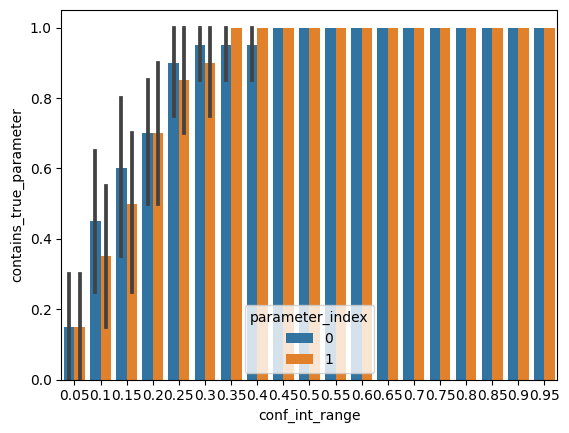

In [47]:
sns.barplot(data=ci_data_df, x="conf_int_range", y="contains_true_parameter", hue="parameter_index")

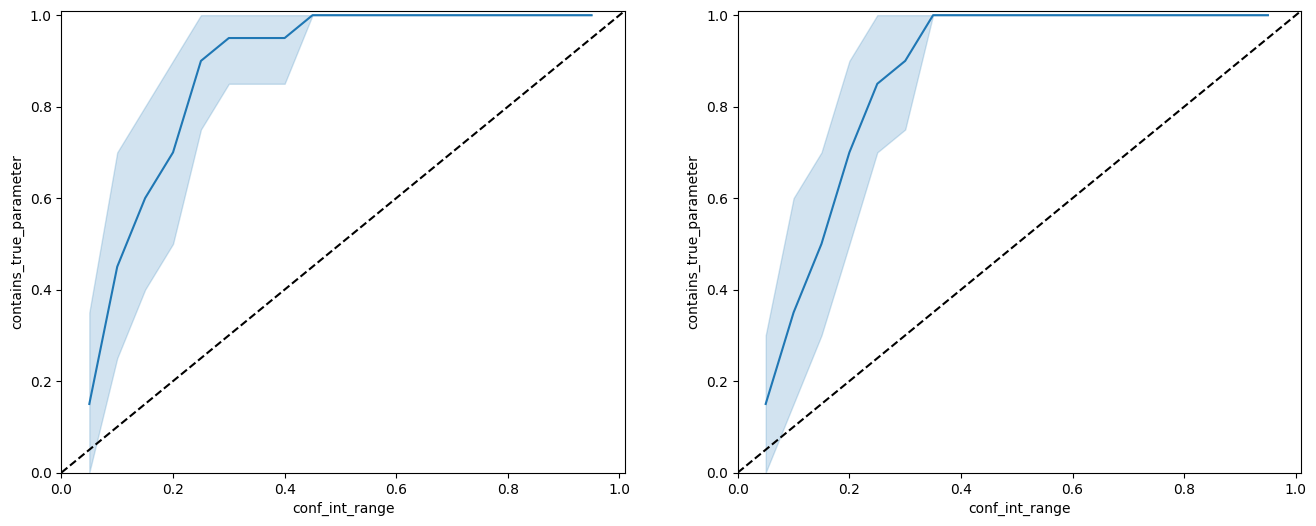

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, param in enumerate(true_params):
    ax = axes[i]
    ci_data = ci_data_df[ci_data_df['true_parameter_value'] == param]
    sns.lineplot(x="conf_int_range", y="contains_true_parameter", data=ci_data, ax=ax)
    diag = (0.0, 1.01)
    ax.plot(diag, diag, linestyle="dashed", color="black")
    ax.set_xlim(diag)
    ax.set_ylim(diag)

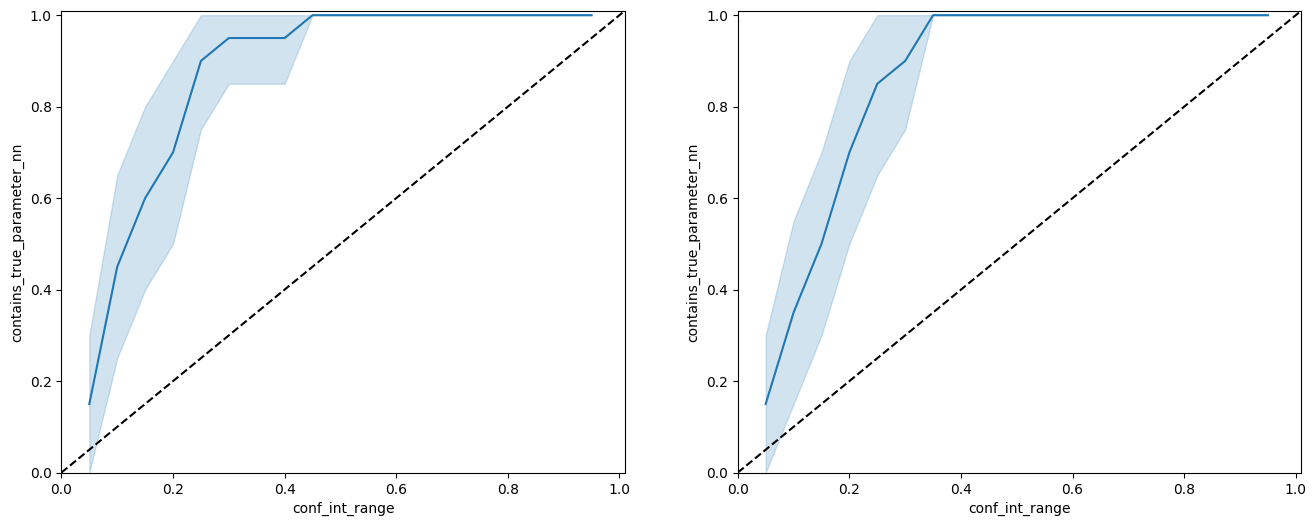

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, param in enumerate(true_params):
    ax = axes[i]
    ci_data = ci_data_df[ci_data_df['true_parameter_value'] == param]
    sns.lineplot(x="conf_int_range", y="contains_true_parameter_nn", data=ci_data, ax=ax)
    diag = (0.0, 1.01)
    ax.plot(diag, diag, linestyle="dashed", color="black")
    ax.set_xlim(diag)
    ax.set_ylim(diag)